In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import cv2
import keras
import numpy as np
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f"Tensorflow ver. {tf.__version__}")

2024-12-17 20:38:13.818484: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734447193.828079   47790 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734447193.831047   47790 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow ver. 2.18.0


In [2]:
IMAGE_SIZE = 224
num_classes = 4
batch = 4
LR = 1e-4
EPOCHS = 20

image_path = "dataset/dataA/CameraRGB/"
mask_path = "dataset/dataA/CameraSeg/"

def load_data():

  TRAIN_X = sorted(glob(os.path.join(image_path, "*.png")))
  train_x = TRAIN_X[:899]
  TRAIN_Y = sorted(glob(os.path.join(mask_path, "*.png")))
  train_y = TRAIN_Y[:899]

  valid_x = TRAIN_X[900:950]
  valid_y = TRAIN_Y[900:950]

  test_x = TRAIN_X[951:999]
  test_y = TRAIN_Y[951:999]

  return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data() 

In [3]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(.5, .2),
  layers.RandomContrast(0.1)],
  )

I0000 00:00:1734447195.106460   47790 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1201 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [4]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    return x
 
 # Function to generate tensorflow dataset 
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.uint8])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    return x, y

num_threads = 4

def tf_dataset_train(x, y, batch=4):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.repeat()
    dataset = dataset.map(tf_parse, num_parallel_calls=num_threads)
    dataset = dataset.batch(batch)
    dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(1)
    return dataset


def tf_dataset_valid(x, y, batch=4):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=500)
    dataset = dataset.repeat()
    dataset = dataset.map(tf_parse, num_parallel_calls=num_threads)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(1)
    return dataset

train_dataset = tf_dataset_train(train_x, train_y)
valid_dataset = tf_dataset_valid(valid_x, valid_y)
test_dataset = tf_dataset_valid(test_x, test_y)

In [5]:
type(train_dataset)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

Unique pixel values in mask: [0 1 2 3]
Unique pixel values in mask: [0 1 2 3]
Unique pixel values in mask: [0 1 2 3]
Unique pixel values in mask: [0 1 2 3]


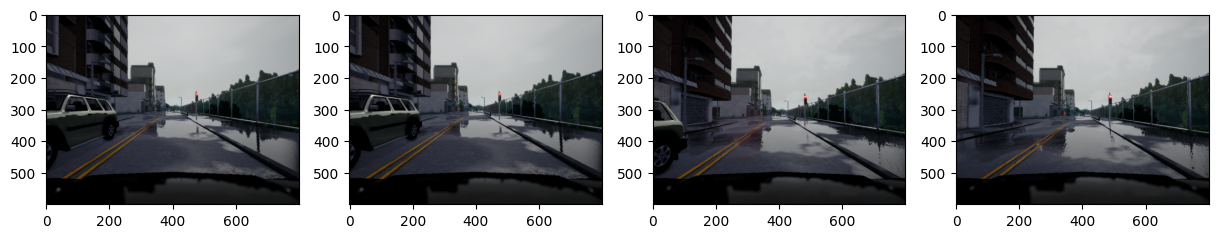

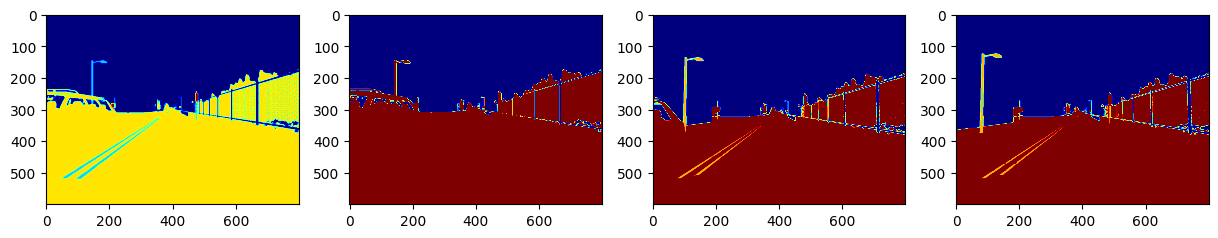

In [6]:
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

def read_gray_scale(y):
    y = cv2.imread(y,cv2.IMREAD_GRAYSCALE)
    print("Unique pixel values in mask:", np.unique(y))
    return y

# Plot samples of images and corresponding masks 
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_x[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_x[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_x[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_x[3]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_gray_scale(train_y[0]),cmap='jet')

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_gray_scale(train_y[1]),cmap='jet')
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_gray_scale(train_y[2]),cmap='jet')
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_gray_scale(train_y[3]),cmap='jet')
imgplot.set_clim(0.0, 1.4)

In [7]:
# Function for conv2d_block (to be used for building decoder of unet)
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

# Function for unet model creation
def unet(n_filters = 16, batchnorm = True, dropout = 0.1, num_classes=4):

    # Contracting Path (encoder)
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    encoder = MobileNetV2(input_tensor=inputs, include_top=False)

    BASE_WEIGHT_PATH = ('https://github.com/fchollet/deep-learning-models/releases/download/v0.6/')
    model_name = 'mobilenet_%s_%d_tf_no_top.h5' % ('1_0', 224)
    weight_path = BASE_WEIGHT_PATH + model_name
    weights_path = keras.utils.get_file(model_name, weight_path)
    encoder.load_weights(weights_path, by_name=True, skip_mismatch=True)

    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output

    x = encoder_output
    x_skip_1 = encoder.get_layer(skip_connection_names[-1]).output # 224x224
    x_skip_2 = encoder.get_layer(skip_connection_names[-2]).output # 112x112
    x_skip_3 = encoder.get_layer(skip_connection_names[-3]).output # 56x56
    x_skip_4 = encoder.get_layer(skip_connection_names[-4]).output # 28x28


    # Expansive Path (decoder)
    u6 = Conv2DTranspose(n_filters * 13, (3, 3), strides = (2, 2), padding = 'same')(x)
    u6 = concatenate([u6, x_skip_1])
    c6 = conv2d_block(u6, n_filters * 13, kernel_size = 3, batchnorm = batchnorm)
    p6 = Dropout(dropout)(c6)

    u7 = Conv2DTranspose(n_filters * 12, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, x_skip_2])
    c7 = conv2d_block(u7, n_filters * 12, kernel_size = 3, batchnorm = batchnorm)
    p7 = Dropout(dropout)(c7)

    u8 = Conv2DTranspose(n_filters * 11, (3, 3), strides = (2, 2), padding = 'same')(p7)
    u8 = concatenate([u8, x_skip_3])
    c8 = conv2d_block(u8, n_filters * 11, kernel_size = 3, batchnorm = batchnorm)
    p7 = Dropout(dropout)(c8)

    u9 = Conv2DTranspose(n_filters * 10, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, x_skip_4])
    c9 = conv2d_block(u9, n_filters * 10, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=inputs, outputs=outputs)
    
    return model

In [8]:
model = unet(n_filters = 16, batchnorm = True, dropout = 0.1, num_classes=4)

#Specify all the encoder layers in a list
encoder_layers = model.layers[0:-22]

#Freeze the encoder layers for transfer learning (so that weights are only changed for the decoder layers druing training)
for layer in encoder_layers:
    layer.trainable = False
    print(layer, layer.trainable)

model.summary()
# tf.keras.utils.plot_model(model, show_shapes=True)

/tmp/ipykernel_47790/4202946773.py:14: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  encoder = MobileNetV2(input_tensor=inputs, include_top=False)


<InputLayer name=input_image, built=True> False
<Conv2D name=Conv1, built=True> False
<BatchNormalization name=bn_Conv1, built=True> False
<ReLU name=Conv1_relu, built=True> False
<DepthwiseConv2D name=expanded_conv_depthwise, built=True> False
<BatchNormalization name=expanded_conv_depthwise_BN, built=True> False
<ReLU name=expanded_conv_depthwise_relu, built=True> False
<Conv2D name=expanded_conv_project, built=True> False
<BatchNormalization name=expanded_conv_project_BN, built=True> False
<Conv2D name=block_1_expand, built=True> False
<BatchNormalization name=block_1_expand_BN, built=True> False
<ReLU name=block_1_expand_relu, built=True> False
<ZeroPadding2D name=block_1_pad, built=True> False
<DepthwiseConv2D name=block_1_depthwise, built=True> False
<BatchNormalization name=block_1_depthwise_BN, built=True> False
<ReLU name=block_1_depthwise_relu, built=True> False
<Conv2D name=block_1_project, built=True> False
<BatchNormalization name=block_1_project_BN, built=True> False
<Con

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_image[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 4,611,556 (17.59 MB)

 Trainable params: 3,993,828 (15.24 MB)

 Non-trainable params: 617,728 (2.36 MB)

In [9]:
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred, smooth=1e-7):
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=4)[Ellipsis,1:])
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [10]:
opt = tf.keras.optimizers.Adam(LR)
metrics = [dice_coef, 'accuracy']
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

# Set up early stopping and reduce learning rate on plateau
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=3, 
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.2,   
    patience=2, 
    min_lr=0.00001,
)

# Set up checkpoint for saving model architecture and weights
checkpoint_filepath = 'checkpoint/middle_mobunet.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [11]:
# Commencement of training
train_steps = len(train_x)//batch
valid_steps = len(valid_x)//batch

if len(train_x) % batch != 0: 
    train_steps += 1
if len(valid_x) % batch != 0: 
    valid_steps += 1

model.fit(
    train_dataset,
    validation_data = valid_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=[model_checkpoint_callback, early_stopping, reduce_lr]
)

Epoch 1/20


I0000 00:00:1734447199.775212   47893 service.cc:148] XLA service 0x7f7b8c002200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734447199.775227   47893 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
I0000 00:00:1734447200.328504   47893 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/225 ━━━━━━━━━━━━━━━━━━━━ 1:26:41 23s/step - accuracy: 0.1489 - dice_coef: 0.1448 - loss: 0.8552

I0000 00:00:1734447219.871374   47893 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


225/225 ━━━━━━━━━━━━━━━━━━━━ 63s 179ms/step - accuracy: 0.5666 - dice_coef: 0.5811 - loss: 0.4189 - val_accuracy: 0.8396 - val_dice_coef: 0.8368 - val_loss: 0.1632 - learning_rate: 1.0000e-04
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 39s 173ms/step - accuracy: 0.7986 - dice_coef: 0.8070 - loss: 0.1930 - val_accuracy: 0.8455 - val_dice_coef: 0.8493 - val_loss: 0.1507 - learning_rate: 1.0000e-04
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 39s 172ms/step - accuracy: 0.7988 - dice_coef: 0.8108 - loss: 0.1892 - val_accuracy: 0.8276 - val_dice_coef: 0.8426 - val_loss: 0.1574 - learning_rate: 1.0000e-04
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 39s 172ms/step - accuracy: 0.8101 - dice_coef: 0.8183 - loss: 0.1817 - val_accuracy: 0.8422 - val_dice_coef: 0.8494 - val_loss: 0.1506 - learning_rate: 1.0000e-04
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 39s 174ms/step - accuracy: 0.8119 - dice_coef: 0.8209 - loss: 0.1791 - val_accuracy: 0.8460 - val_dice_coef: 0.8547 - val_loss: 0.1453 - learning_rate: 2.0000e

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
(1, 224, 224, 4)
(1, 224, 224)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 224, 224, 1)
(224, 224, 1)


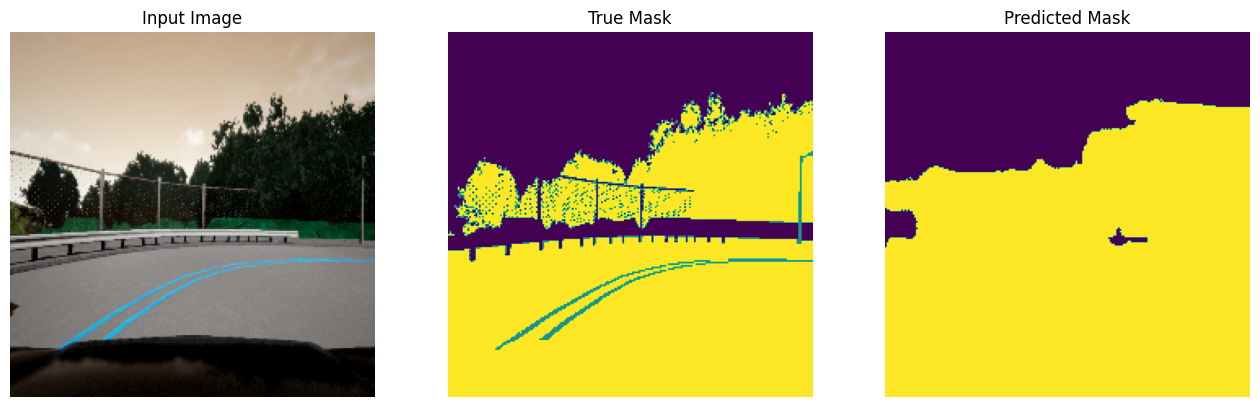

In [12]:
def display_sample(display_list):
    plt.figure(figsize=(16, 16))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
    
def create_mask(pred_mask):
    print(pred_mask.shape)
    # print(pred_mask)
    pred_mask = tf.argmax(pred_mask, axis=-1) 
    # print(pred_mask)
    print(pred_mask.shape)
    print(type(pred_mask))
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    print(pred_mask.shape)
    return pred_mask
    
def show_predictions():
    one_img = sample_image[0][tf.newaxis, ...] 
    prediction = model.predict(one_img)
    pred_mask = create_mask(prediction)
    # print(sample_mask[0])
    print(sample_mask[0].shape)
    display_sample([sample_image[0], sample_mask[0], pred_mask[0]])
    
for image, mask in test_dataset.take(8):
    sample_image, sample_mask = image, mask

show_predictions()